<a href="https://colab.research.google.com/github/marcosallustio/ML-Project/blob/main/progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf

import os
import math
import numpy as np
import pandas as pd


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory


from IPython.display import display

In [3]:
!pip install wget

import os
import wget
import tarfile

data_dir = '/content/iaprtc12'
url = 'http://www-i6.informatik.rwth-aachen.de/imageclef/resources/iaprtc12.tgz'

if not os.path.exists(data_dir):
    print('Downloading IAPR TC-12 data set (1.8 GB)...')
    os.makedirs(data_dir)
    try:
        wget.download(url, os.path.join(data_dir, 'iaprtc12.tgz'))
        tarfile.open(os.path.join(data_dir, 'iaprtc12.tgz')).extractall(data_dir)
        os.remove(os.path.join(data_dir, 'iaprtc12.tgz'))
    except:
        print('An error occurred during the download or extraction process.')
else:
    print('IAPR TC-12 data set already exists.')

print('Done.\n')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=00219520c15a7c40a83b5bd7ead7822df27d4d35bab1ad4477caa00ca3f49057
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Done.



In [4]:
base_path = 'iaprtc12/iaprtc12/images'

In [5]:
train_ds = keras.preprocessing.image_dataset_from_directory(base_path,
                                                            batch_size=8,
                                                            image_size=[300,300],
                                                            labels=None,
                                                            subset='training',
                                                            validation_split = 0.2,
                                                            shuffle=True,
                                                            seed=1)

Found 20000 files belonging to 1 classes.
Using 16000 files for training.


In [6]:
from numpy.core.fromnumeric import size
val_ds = keras.preprocessing.image_dataset_from_directory(base_path,
                                                            batch_size=8,
                                                            image_size=[300,300],
                                                            labels=None,
                                                            subset='validation',
                                                            validation_split = 0.2,
                                                            shuffle=True,
                                                            seed=1)

Found 20000 files belonging to 1 classes.
Using 4000 files for validation.


In [7]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
val_ds = val_ds.map(scaling)

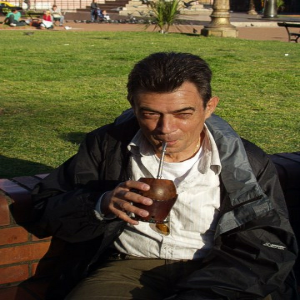

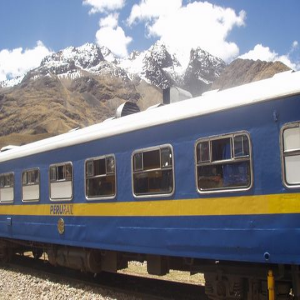

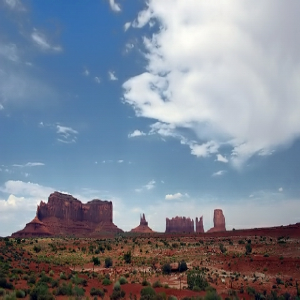

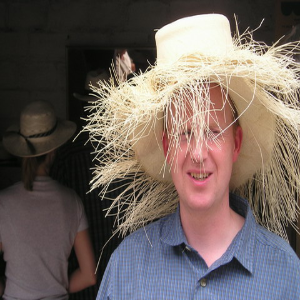

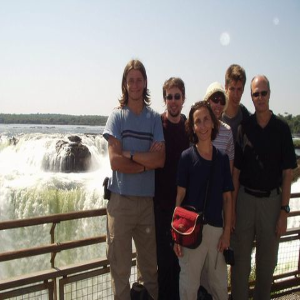

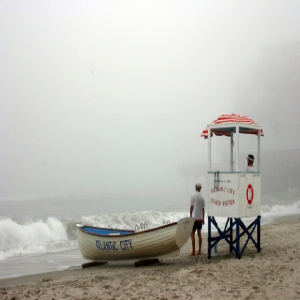

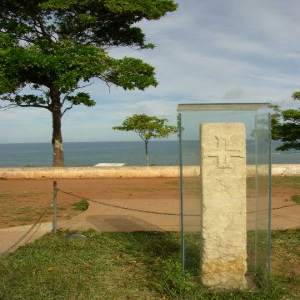

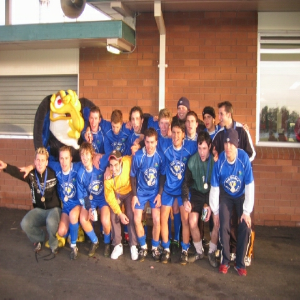

In [7]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

In [8]:
def process_input(input, input_size):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")
    


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y

In [9]:
crop_size = 300
upscale_factor = 4
input_size = crop_size // upscale_factor

train_ds = train_ds.map(
    lambda x: (process_input(x , input_size), process_target(x))
)


val_ds = val_ds.map(
    lambda x: (process_input(x , input_size), process_target(x))
)

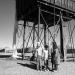

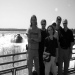

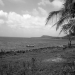

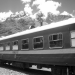

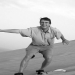

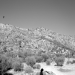

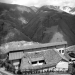

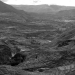

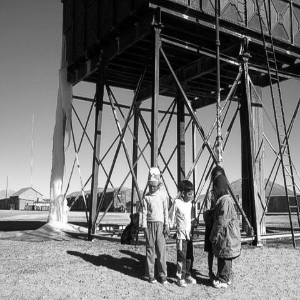

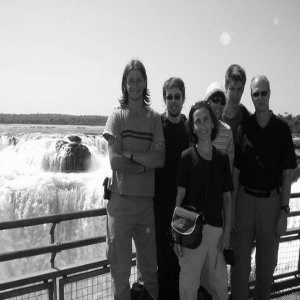

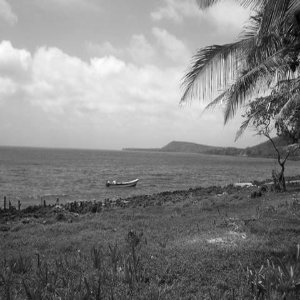

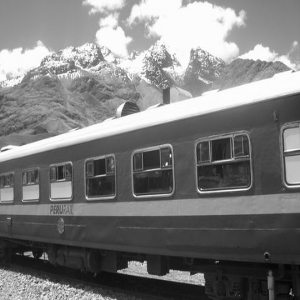

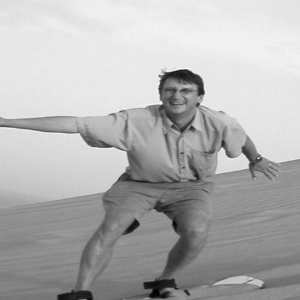

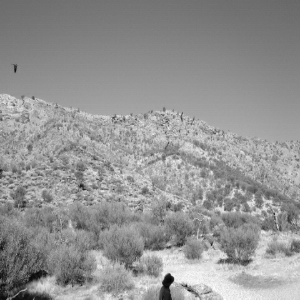

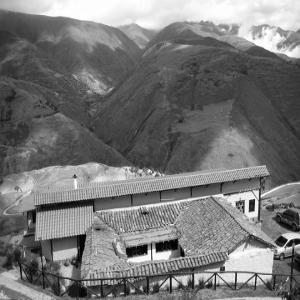

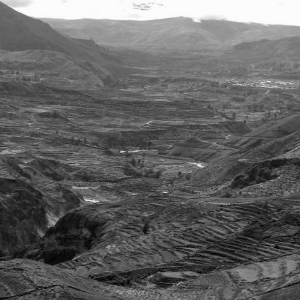

In [10]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

In [10]:
def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    super_resolution = super_resolution * 255.0 // 1
    high_resolution = high_resolution * 255.0 // 1
    
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value

In [11]:
# Loss functtion
def ssim_loss(y_true, y_pred):
  return 1-tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

1 modello

In [13]:
channels = 1
upscale_factor=4

# Architecture definition v1
inputs = keras.Input(shape =(None, None, 1))

x = keras.layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)


x = keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)


x = keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)

outputs = x = keras.layers.Conv2DTranspose(1, 4, strides=(4, 4), padding='same', activation="relu")(x)


#x = keras.layers.Conv2D(channels* (upscale_factor ** 2), 3, padding="same", activation='relu')(x)
#outputs = tf.nn.depth_to_space(x, upscale_factor)


net = keras.Model(inputs, outputs)


net.compile(optimizer='adam', 
            loss='mse',
            metrics=PSNR)

In [14]:
net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    640       
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_transpose (Conv2DTra  (None, None, None, 1)    1025      
 nspose)                                                         
                                                                 
Total params: 75,521
Trainable params: 75,521
Non-trainable params: 0
_________________________________________________________

2 modello

In [15]:
channels = 1
upscale_factor=4

# Architecture definition v1
inputs = keras.Input(shape =(None, None, 1))

x = keras.layers.Conv2D(64, 3, padding="same", activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.001))(inputs)


x = keras.layers.Conv2D(64, 3, padding="same", activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)


x = keras.layers.Conv2D(64, 3, padding="same", activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)

outputs = x = keras.layers.Conv2DTranspose(1, 4, strides=(4, 4), padding='same', activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)


#x = keras.layers.Conv2D(channels* (upscale_factor ** 2), 3, padding="same", activation='relu')(x)
#outputs = tf.nn.depth_to_space(x, upscale_factor)


net1 = keras.Model(inputs, outputs)


net1.compile(optimizer='adam', 
            loss='mse',
            metrics=PSNR)

3 modello

In [20]:
channels = 1
upscale_factor=4

# Architecture definition v1
inputs = keras.Input(shape =(None, None, 1))

x = keras.layers.Conv2D(8, 3, padding="same", activation="relu")(inputs)


x = keras.layers.Conv2D(16, 3, padding="same", activation="relu")(x)


x = keras.layers.Conv2D(32, 3, padding="same", activation="relu")(x)


x = keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)





outputs = x = keras.layers.Conv2DTranspose(1, 4, strides=(4, 4), padding='same', activation="relu")(x)


#x = keras.layers.Conv2D(channels* (upscale_factor ** 2), 3, padding="same", activation='relu')(x)
#outputs = tf.nn.depth_to_space(x, upscale_factor)


net2 = keras.Model(inputs, outputs)


net2.compile(optimizer='adam', 
            loss='mse',
            metrics=PSNR)

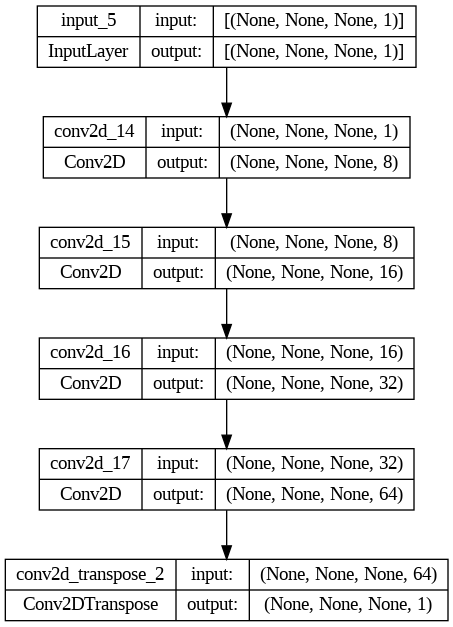

In [21]:
keras.utils.plot_model(net2,show_shapes=True)

In [22]:
net2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_14 (Conv2D)          (None, None, None, 8)     80        
                                                                 
 conv2d_15 (Conv2D)          (None, None, None, 16)    1168      
                                                                 
 conv2d_16 (Conv2D)          (None, None, None, 32)    4640      
                                                                 
 conv2d_17 (Conv2D)          (None, None, None, 64)    18496     
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, None, None, 1)    1025      
 ranspose)                                                       
                                                           

In [23]:
history = net2.fit(train_ds,
          epochs=100,
          validation_data=val_ds);

Epoch 1/100
2000/2000 [==============================] - 77s 37ms/step - loss: 0.0059 - PSNR: 25.4318 - val_loss: 0.0032 - val_PSNR: 26.3386
Epoch 2/100
2000/2000 [==============================] - 82s 41ms/step - loss: 0.0031 - PSNR: 26.3456 - val_loss: 0.0031 - val_PSNR: 26.6169
Epoch 3/100
2000/2000 [==============================] - 74s 37ms/step - loss: 0.0031 - PSNR: 26.5745 - val_loss: 0.0031 - val_PSNR: 26.6184
Epoch 4/100
2000/2000 [==============================] - 74s 37ms/step - loss: 0.0031 - PSNR: 26.3836 - val_loss: 0.0031 - val_PSNR: 26.7542
Epoch 5/100
2000/2000 [==============================] - 73s 36ms/step - loss: 0.0030 - PSNR: 26.4934 - val_loss: 0.0031 - val_PSNR: 26.7222
Epoch 6/100
2000/2000 [==============================] - 82s 41ms/step - loss: 0.0030 - PSNR: 26.4094 - val_loss: 0.0030 - val_PSNR: 26.5737
Epoch 7/100
2000/2000 [==============================] - 82s 41ms/step - loss: 0.0030 - PSNR: 26.5611 - val_loss: 0.0030 - val_PSNR: 26.4924
Epoch 8/100
2

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor)    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32")  / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

In [25]:
test_path='iaprtc12/iaprtc12/additional_images/27'
test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

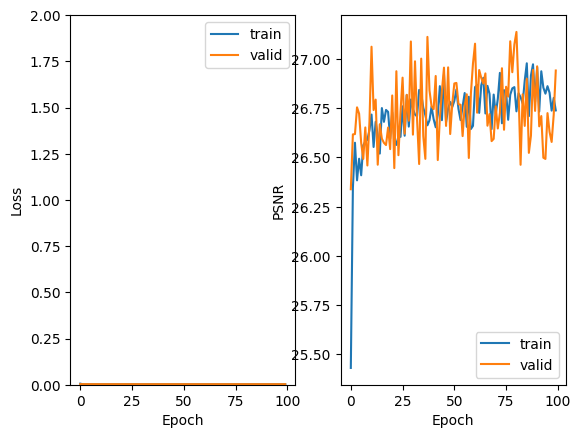

In [35]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history["PSNR"])
plt.plot(history.history['val_PSNR'])
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend(['train', 'valid'])

1/1 [==============================] - 0s 326ms/step
PSNR of low resolution image and high resolution image is 22.6496
PSNR of predict and high resolution is 23.8179


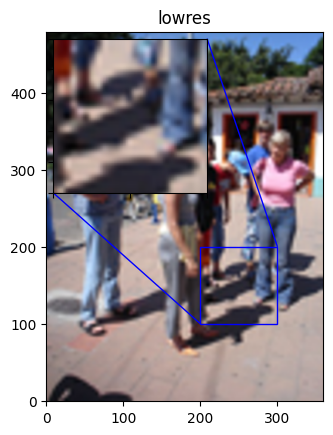

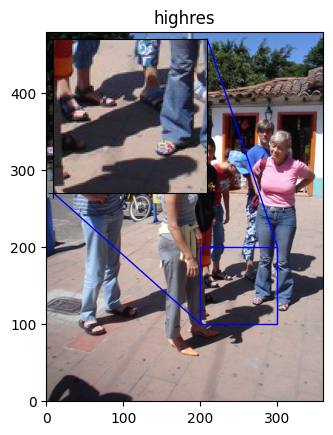

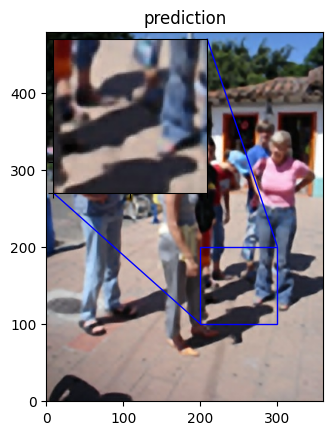

1/1 [==============================] - 0s 238ms/step
PSNR of low resolution image and high resolution image is 22.4493
PSNR of predict and high resolution is 23.5039


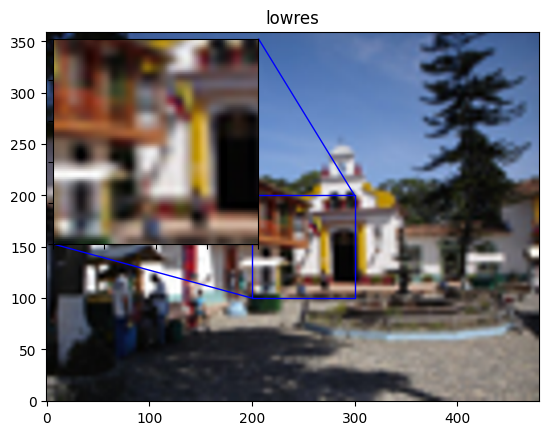

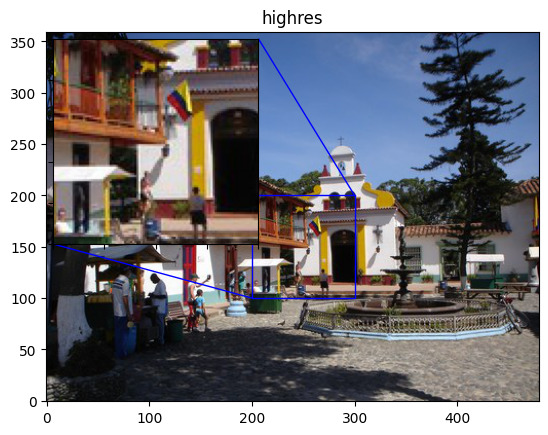

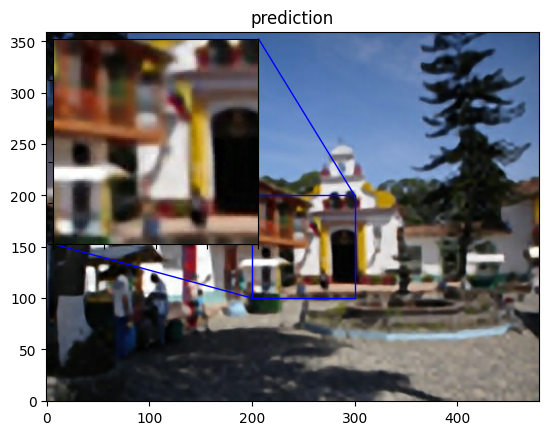

Avg. PSNR of lowres images is 4.5099
Avg. PSNR of reconstructions is 4.7322


In [26]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0



for index, test_img_path in enumerate(test_img_paths[50:52]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))

    prediction = upscale_image(net2, lowres_input)

    lowres_img = lowres_input.resize((w, h))
    
    
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))